In [1]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Chargement des données depuis le CSV avec le bon séparateur
data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')

# Montrer toutes les colonnes
pd.set_option('display.max_columns', None)

C:\Users\Mathieu Bosse\AppData\Local\Temp\ipykernel_15676\1518553703.py:9: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')


In [2]:
import pandas as pd

def get_cols_to_keep(df: pd.DataFrame):
    """
    Fonction pour identifier les colonnes à conserver en fonction du pourcentage de valeurs manquantes.

    Paramètres :
        df (pd.DataFrame) : Le DataFrame à analyser.

    Retourne :
        List[str] : Une liste des noms de colonnes à conserver.
    """
    nb_lignes = len(df)
    colonnes_a_garder = []

    # Itérer à travers chaque colonne dans le DataFrame
    for col in df.columns:
        # Compter le nombre de valeurs manquantes dans la colonne actuelle
        nb_na = df[col].isnull().sum()

        # Vérifier si le pourcentage de valeurs manquantes est supérieur à 50%
        if 100 * nb_na / nb_lignes <= 50:
            # Si le pourcentage n'est pas supérieur à 50%, ajouter la colonne à la liste
            colonnes_a_garder.append(col)

    # Ajouter les colonnes supplémentaires à la fin de la liste
    colonnes_a_garder.extend(['fruits-vegetables-nuts_100g','pnns_groups_1', 'pnns_groups_2'])

    # Afficher les colonnes à supprimer
    colonnes_a_supprimer = [col for col in df.columns if col not in colonnes_a_garder]
    print(colonnes_a_supprimer)
    
    # Retourner la liste des colonnes à conserver
    return colonnes_a_garder


def get_columns_to_drop(df: pd.DataFrame):
    """
    Fonction pour identifier les colonnes à supprimer en fonction de leur nom.

    Paramètres :
        df (pd.DataFrame) : Le DataFrame à analyser.

    Retourne :
        List[str] : Une liste des noms de colonnes à supprimer.
    """
    colonnes_a_supprimer = []

    # Itérer à travers chaque colonne dans le DataFrame
    for col1 in df.columns:
        for col2 in df.columns:
            # Vérifier si la colonne col2 est une version "_tags" de col1
            if col2 == col1 + "_tags":
                # Ajouter col1 à la liste des colonnes à supprimer
                colonnes_a_supprimer.append(col1)
                break

    # Retourner la liste des colonnes à supprimer
    return colonnes_a_supprimer


# Nettoyage – Filtrage des features et produits

### A. Valeurs manquantes

In [3]:
# Appeler la fonction pour obtenir la liste des colonnes à conserver pour le DataFrame 'data'
colonnes_a_garder = get_cols_to_keep(data)

# Créer un nouveau DataFrame 'data_cleaned' en sélectionnant uniquement les colonnes à conserver
data_cleaned = data[colonnes_a_garder]

# Afficher les colonnes du DataFrame nettoyé
print(data_cleaned.columns)

# Afficher les 5 premières lignes du dataframe
data_cleaned.head()



['generic_name', 'quantity', 'packaging', 'packaging_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'no_nutriments', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'energy-from-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,countries,countries_tags,countries_fr,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states,states_tags,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fruits-vegetables-nuts_100g,pnns_groups_1,pnns_groups_2
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,0.0,0.0,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,14.0,14.0,NaN,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,US,en:united-states,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,0.0,0.0,b,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0,NaN,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,Grizzlies,grizzlies,US,en:united-states,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,0.0,0.0,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,12.0,12.0,NaN,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,Bob's Red Mill,bob-s-red-mill,US,en:united-states,États-Unis,Organic polenta,35 g (0.25 cup),0.0,[ organic-polenta -> en:organic-polenta ] [...,0.0,0.0,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### B. Redondant
On avait cleané une partie des catégories dans la première version du fichier

In [4]:
# Appeler la fonction pour obtenir la liste des colonnes à supprimer pour le DataFrame nettoyé
colonnes_a_supprimer = get_columns_to_drop(data_cleaned)

# Afficher la liste des colonnes à supprimer
print("Colonnes à supprimer :", colonnes_a_supprimer)

# Créer un nouveau DataFrame 'data_cleaned_2' en supprimant les colonnes identifiées
data_cleaned_2 = data_cleaned.drop(colonnes_a_supprimer, axis=1)

# Mettre à jour le DataFrame original 'data' avec le DataFrame nettoyé 'data_cleaned_2'
data = data_cleaned_2

# Afficher colonnes du DataFrame mis à jour
data.columns



Colonnes à supprimer : ['brands', 'countries', 'states']


Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'brands_tags', 'countries_tags', 'countries_fr', 'ingredients_text',
       'serving_size', 'additives_n', 'additives',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'states_tags', 'states_fr', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'fruits-vegetables-nuts_100g',
       'pnns_groups_1', 'pnns_groups_2'],
      dtype='object')

Sodium et sel représentent les mêmes données

In [5]:
data = data.drop('sodium_100g', axis=1)

nutrition-score-uk_100g 

In [6]:
data = data.drop('nutrition-score-uk_100g', axis=1)

countries_fr

In [7]:
data = data.drop('countries_fr', axis=1)

### C. Données contextuelles

In [8]:
meta_features = ['created_datetime','last_modified_datetime','last_modified_t', 'created_t','url', 'code', 'states_tags', 'creator']
data = data.drop(meta_features, axis=1)

In [9]:
data.columns

Index(['product_name', 'brands_tags', 'countries_tags', 'ingredients_text',
       'serving_size', 'additives_n', 'additives',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'states_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'nutrition-score-fr_100g', 'fruits-vegetables-nuts_100g',
       'pnns_groups_1', 'pnns_groups_2'],
      dtype='object')

### D. Autres


Doublon

In [10]:
# Vérifier s'il reste des doublons
duplicates_remaining = data.duplicated()
print(f"Nombre de doublons avant : {duplicates_remaining.sum()}")

data = data.drop_duplicates()

# Vérifier s'il reste des doublons
duplicates_remaining = data.duplicated()
print(f"Nombre de doublons restants : {duplicates_remaining.sum()}")

Nombre de doublons avant : 16009
Nombre de doublons restants : 0


# Nettoyage – Valeurs aberrantes

### A. Correction des Valeurs <> 100g


Cette partie du code crée une liste colonnes_100g qui contient uniquement les colonnes se terminant par "_100g". Cela est fait en utilisant une compréhension de liste pour filtrer les colonnes pertinentes à partir de la liste complète toutes_les_colonnes.

In [11]:
# Liste complète de toutes les colonnes
toutes_les_colonnes = ['product_name', 'brands_tags', 'countries_tags', 'ingredients_text',
       'serving_size', 'additives_n', 'additives',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'states_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'nutrition-score-fr_100g']

# Liste des colonnes se terminant par "_100g"
colonnes_100g = [col for col in toutes_les_colonnes if col.endswith("_100g")]
colonnes_100g.remove('energy_100g')
colonnes_100g.remove('nutrition-score-fr_100g')


# Affichage de la liste des colonnes "_100g"
print(colonnes_100g) 

['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']


In [12]:
# Afficher les statistiques descriptives avant le remplacement
print("Statistiques descriptives avant remplacement :")
print(data[colonnes_100g].describe())

# 'colonnes_100g' est la liste des colonnes que vous avez traitées

for colonne in colonnes_100g:
    # Remplacer les valeurs aberrantes par NaN
    data[colonne] = data[colonne].mask((data[colonne] < 0) | (data[colonne] > 100))

# Afficher les statistiques descriptives après le remplacement
print("\nStatistiques descriptives après remplacement :")
print(data[colonnes_100g].describe())

Statistiques descriptives avant remplacement :


            fat_100g  saturated-fat_100g  carbohydrates_100g    sugars_100g  \
count  240803.000000       227129.000000       240503.000000  242318.000000   
mean       12.700077            5.132605           32.134161      15.986655   
std        17.436180            8.016050           29.708818      22.305163   
min         0.000000            0.000000            0.000000     -17.860000   
25%         0.000000            0.000000            6.000000       1.300000   
50%         5.000000            1.790000           20.990000       5.710000   
75%        20.000000            7.140000           58.330000      24.000000   
max       714.290000          550.000000         2916.670000    3520.000000   

          fiber_100g  proteins_100g      salt_100g  
count  198814.000000  256823.000000  252421.000000  
mean        2.861715       7.091283       2.034493  
std        12.924571       8.405597     129.048946  
min        -6.700000    -800.000000       0.000000  
25%         0.000000   

Filtrage des lignes dont la La somme des ingrédients est > 100g

In [13]:
colonnes_100g.remove('sugars_100g')
colonnes_100g.remove('saturated-fat_100g')

# Création de la nouvelle colonne somme
data['sum_100g'] = data[colonnes_100g].sum(axis=1)

# Afficher les statistiques de la somme
print("Statistiques descriptives avant filtrage :")
print(data['sum_100g'].describe())

# Calcul du pourcentage > 100
pourcentage_sup_100 = (data['sum_100g'] > 100).mean() * 100

# Affichage du pourcentage
print(f"Pourcentage des éléments dans la colonne 'sum_100g' supérieurs à 100 : {pourcentage_sup_100}%")

# Filtrer les lignes dont la valeur dans la colonne 'sum_100g' est supérieure à 100
data = data[data['sum_100g'] <= 100]

# Afficher les statistiques descriptives après filtrage
print("Statistiques descriptives après filtrage :")
print(data['sum_100g'].describe())

Statistiques descriptives avant filtrage :
count    304763.000000
mean         44.515769
std          38.157053
min           0.000000
25%           8.864870
50%          34.752440
75%          86.431250
max         250.000000
Name: sum_100g, dtype: float64
Pourcentage des éléments dans la colonne 'sum_100g' supérieurs à 100 : 6.944740667338227%
Statistiques descriptives après filtrage :
count    283598.000000
mean         39.959043
std          35.496592
min           0.000000
25%           7.500000
50%          29.174210
75%          76.217820
max         100.000000
Name: sum_100g, dtype: float64


### B. Correction des Valeurs Nutritionnelles

Objectif : Ajuster 'saturated_fat' et 'sugar' pour assurer la cohérence.
- Remplacer 'saturated_fat' > 'fat' par 100g.
- Remplacer 'sugar' > 'carbohydrates' par 100g.

In [14]:
# Remplacer les valeurs de 'saturated_fat' supérieures à 'fat' par NaN
data['saturated-fat_100g'] = data['saturated-fat_100g'].mask(data['saturated-fat_100g'] > data['fat_100g'])

# Remplacer les valeurs de 'sugar' supérieures à 'carbohydrates' par NaN
data['sugars_100g'] = data['sugars_100g'].mask(data['sugars_100g'] > data['carbohydrates_100g'])

L'aliment à la densité calorique la plus élevée est l'huile, puisqu'elle contient 100% de lipides et apporte 3765,6 calories/100g. Nous l'utilisons donc comme seuil de valeur pour la détection de données aberrantes.

In [15]:
# Seuil de densité calorique pour l'huile
seuil_densite_calorique = 3800

# Remplacement des valeurs aberrantes par NaN
data['energy_100g'] = data['energy_100g'].mask(data['energy_100g'] > seuil_densite_calorique)

### C. Correction de la catégorie pays

Dans cette section, nous appliquerons une expression régulière simple pour éliminer les codes de langue ("en:") des balises de pays dans notre ensemble de données.

In [16]:
# Suppression du préfixe "en:" pour chaque valeur dans la colonne 'countries_tags'
data['countries_tags'] = data['countries_tags'].str.replace('en:', '')

In [17]:
print(data.columns)

Index(['product_name', 'brands_tags', 'countries_tags', 'ingredients_text',
       'serving_size', 'additives_n', 'additives',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'states_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'nutrition-score-fr_100g', 'fruits-vegetables-nuts_100g',
       'pnns_groups_1', 'pnns_groups_2', 'sum_100g'],
      dtype='object')


### C. Correction de la valeur de nutriscore

In [18]:
import numpy as np
from tqdm import tqdm

# Définir les seuils pour la densité énergétique, les sucres, les acides gras saturés et le sodium
seuils = {
    'energy_100g': [335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350],
    'sugars_100g': [4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45],
    'saturated-fat_100g': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'salt_100g': [0.2286, 0.4572, 0.6858, 0.9144, 1.143, 1.3716, 1.6002, 1.8288, 2.0574, 2.286]
}

# Fonction pour calculer la composante N du Nutri-Score en fonction des seuils
def calculate_nutriscore_component_n(row):
    # Vérifier si l'une des valeurs est NaN
    if any(np.isnan(row[nutrient]) for nutrient in seuils.keys()):
        return np.nan
    else:
        n_points = 0
        for nutrient, values in seuils.items():
            n_points += sum(row[nutrient] > value for value in values)
        return n_points

# Appliquer la fonction de calcul de la composante N à chaque ligne du DataFrame avec tqdm
tqdm.pandas(desc="Calcul de la composante N")
data['nutriscore_component_n'] = data.progress_apply(calculate_nutriscore_component_n, axis=1)

# Afficher les statistiques descriptives de la composante N
print("Statistiques descriptives de la composante N du Nutri-Score :")
print(data['nutriscore_component_n'].describe())


Calcul de la composante N:   0%|          | 0/283598 [00:00<?, ?it/s]

Calcul de la composante N: 100%|██████████| 283598/283598 [00:36<00:00, 7812.49it/s] 

Statistiques descriptives de la composante N du Nutri-Score :
count    198435.000000
mean         11.507451
std           7.852862
min           0.000000
25%           4.000000
50%          11.000000
75%          18.000000
max          37.000000
Name: nutriscore_component_n, dtype: float64


In [19]:
# Seuils favorables
seuils_favorables = {
    'fiber_100g': [0.9, 1.9, 2.8, 3.7, 4.7],
    'proteins_100g': [1.6, 3.2, 4.8, 6.4, 8.0]
}

# Fonction pour calculer la composante P du Nutri-Score en fonction des seuils favorables
def calculate_nutriscore_component_p(row):
    p_points = 0
    
    # Vérifier si l'une des deux valeurs est nulle
    if pd.isna(row['fiber_100g']) or pd.isna(row['proteins_100g']):
        return np.nan
    
    for nutrient, values in seuils_favorables.items():
        p_points += sum(row[nutrient] > value for value in values)
    
    # Ajouter la règle spéciale si la valeur de 'fruits-vegetables-nuts_100g' n'est pas NaN
    fruits_vegetables_nuts_value = row['fruits-vegetables-nuts_100g']
    if pd.isna(fruits_vegetables_nuts_value):
        return np.nan

    if fruits_vegetables_nuts_value > 80:
        p_points += 5
    elif fruits_vegetables_nuts_value > 60:
        p_points += 2
    elif fruits_vegetables_nuts_value > 40:
        p_points += 1
    
    return p_points

# Appliquer la fonction de calcul de la composante P à chaque ligne du DataFrame avec tqdm
tqdm.pandas(desc="Calcul de la composante P")
data['nutriscore_component_p'] = data.progress_apply(calculate_nutriscore_component_p, axis=1)

# Afficher les statistiques descriptives de la composante P
print("Statistiques descriptives de la composante P du Nutri-Score :")
print(data['nutriscore_component_p'].describe())



Calcul de la composante P: 100%|██████████| 283598/283598 [00:11<00:00, 24870.76it/s]

Statistiques descriptives de la composante P du Nutri-Score :
count    1890.000000
mean        3.862434
std         3.059688
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        15.000000
Name: nutriscore_component_p, dtype: float64


In [20]:
# Filtrer les aliments ayant une composante P de 15 points
aliments_15_points = data[data['nutriscore_component_p'] == 15]

# Afficher les aliments
print("Aliments avec une composante P de 15 points :")
print(aliments_15_points[['product_name', 'nutriscore_component_p']])

Aliments avec une composante P de 15 points :
                                             product_name  \
128524                                      Ginger & Goji   
177017                                            Walnuts   
196733  Bénénuts Plaisir Brut Mélange raisins amandes ...   
203671                               Amandes Décortiquées   
210214                                   Mélange Apéritif   
221824                        Amandes crues décortiquées    
227866                          Lentilles vertes du Berry   
240608                                   Lentilles corail   
244734                          Roucadil Baies De Goji ST   
252040                                     Baies De Goji    
271179                      Heritage Smooth Peanut Butter   
276121        Veggie Burger Quinoa, Betteraves Et Amandes   
276779                                            Amandes   
276781                                   Cerneaux de noix   

        nutriscore_component_p  
12852

In [21]:
import numpy as np

# Créer la colonne composante totale (N - P) avec gestion des valeurs nulles
data['nutriscore_component'] = np.where(
    pd.notna(data['nutriscore_component_n']) & pd.notna(data['nutriscore_component_p']),
    data['nutriscore_component_n'] - data['nutriscore_component_p'],
    np.nan
)

# Afficher les statistiques descriptives de la composante totale
print("Statistiques descriptives de la composante totale du Nutri-Score :")
print(data['nutriscore_component'].describe())


Statistiques descriptives de la composante totale du Nutri-Score :
count    1868.000000
mean        3.600107
std         6.260643
min       -12.000000
25%         0.000000
50%         2.000000
75%         8.000000
max        25.000000
Name: nutriscore_component, dtype: float64


In [22]:
# Sélectionner 4 exemples aléatoires du jeu de données
random_samples = data.sample(n=4, random_state=43)

# Afficher les exemples de calcul de la composante N
for index, row in random_samples.iterrows():
    nutriscore_component_n = calculate_nutriscore_component_n(row)
    print(f"Exemple pour l'index {index}: Composante N du Nutri-Score = {nutriscore_component_n}")

Exemple pour l'index 186042: Composante N du Nutri-Score = 3
Exemple pour l'index 128974: Composante N du Nutri-Score = nan
Exemple pour l'index 313303: Composante N du Nutri-Score = 25
Exemple pour l'index 282111: Composante N du Nutri-Score = 2


In [23]:
data.head()

,product_name,brands_tags,countries_tags,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g,fruits-vegetables-nuts_100g,pnns_groups_1,pnns_groups_2,sum_100g,nutriscore_component_n,nutriscore_component_p,nutriscore_component
0,Farine de blé noir,ferme-t-y-r-nao,france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
4,Organic Polenta,bob-s-red-mill,united-states,Organic polenta,35 g (0.25 cup),0.0,[ organic-polenta -> en:organic-polenta ] [...,0.0,0.0,NaN,"A compléter,Informations nutritionnelles compl...",1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,92.84,NaN,NaN,NaN
6,Organic Long Grain White Rice,lundberg,united-states,Organic long grain white rice,45 g (0.25 cup),0.0,[ organic-long-grain-white-rice -> en:organic...,0.0,0.0,NaN,"A compléter,Informations nutritionnelles compl...",1490.0,NaN,NaN,80.00,NaN,NaN,8.89,NaN,NaN,NaN,NaN,NaN,88.89,NaN,NaN,NaN
9,Organic Sunflower Oil,napa-valley-naturals,united-states,"Organic expeller pressed, refined high oleic s...",14 g (1 Tbsp),0.0,[ organic-expeller-pressed -> en:organic-expe...,0.0,0.0,NaN,"A compléter,Informations nutritionnelles compl...",3586.0,100.00,7.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN,NaN,NaN
10,Organic Adzuki Beans,unfi,united-states,Organic adzuki beans,48 g (0.25 cup),0.0,[ organic-adzuki-beans -> en:organic-adzuki-b...,0.0,0.0,NaN,"A compléter,Informations nutritionnelles compl...",1393.0,1.04,NaN,62.50,NaN,12.5,22.92,NaN,NaN,NaN,NaN,NaN,98.96,NaN,NaN,NaN


In [24]:
# Définir les conditions pour chaque intervalle
conditions = [
    (data['nutriscore_component'] >= -13) & (data['nutriscore_component'] <= 1),
    (data['nutriscore_component'] >= 2) & (data['nutriscore_component'] <= 5),
    (data['nutriscore_component'] >= 6) & (data['nutriscore_component'] <= 9),
    (data['nutriscore_component'] >= 10) & (data['nutriscore_component'] <= 28)
]

# Définir les valeurs correspondantes pour chaque intervalle
valeurs_nutriscore = ['B', 'C', 'D', 'E']

# Appliquer les conditions pour créer une nouvelle colonne 'nutriscore_final'
data['nutriscore_final'] = np.select(conditions, valeurs_nutriscore, default=np.nan)

# Remplacer 'nan' par np.nan dans la colonne 'nutriscore_final'
data['nutriscore_final'] = data['nutriscore_final'].replace('nan', np.nan)

# Afficher les premières lignes du DataFrame avec la nouvelle colonne
print(data[['nutriscore_component', 'nutriscore_final', 'nutrition_grade_fr']].head())


    nutriscore_component nutriscore_final nutrition_grade_fr
0                    NaN              NaN                NaN
4                    NaN              NaN                NaN
6                    NaN              NaN                NaN
9                    NaN              NaN                NaN
10                   NaN              NaN                NaN


In [25]:
# Sélectionner les 5 premières lignes où 'nutriscore_final' n'est pas nul
resultats_non_nuls = data.dropna(subset=['nutriscore_final']).head(20)

# Afficher les résultats avec la colonne 'product_name'
print(resultats_non_nuls[['product_name', 'nutriscore_component', 'nutriscore_final', 'nutrition_grade_fr']])



                                            product_name  \
283                                     Cakes aux Fruits   
509                           Maple syrup & pecan cookie   
564                         Pur Soup' Velouté de légumes   
12967                               Chef's style carrots   
13133                                       Lychee drink   
28085                         Sauce Barbecue Smoky Sweet   
54999                  Malt O Meal Cereal Frosted Flakes   
57934                  Melange aux epices pour guacamole   
66195  Grains De Chocolat à Cuisson Chipits (chocolat...   
66544                Céréales Koala Croquant Biologiques   
66708                 Boisson Réfrigérée Fuitopia Fruits   
66815                            Pommes de terres lavées   
66946  (Barcode Clash) Houmous with extra virgin oliv...   
67268                                       Avocado feta   
67479                                    Sauce à Lasagne   
67787                 Céréales Reese (be

In [26]:
# Afficher plus de détails pour la ligne 13133
print(data.iloc[282])

product_name                                                                 Exploding Candy
brands_tags                                                                      angry-birds
countries_tags                                                                 united-states
ingredients_text                           Sucrose, lactose (milk), corn syrup solids, na...
serving_size                                                                   3 g (1 POUCH)
additives_n                                                                              1.0
additives                                   [ sucrose -> en:sucrose  ]  [ lactose -> en:l...
ingredients_from_palm_oil_n                                                              0.0
ingredients_that_may_be_from_palm_oil_n                                                  0.0
nutrition_grade_fr                                                                         d
states_fr                                  A compléter,Informations nu

# Nettoyage – Valeurs manquantes

### A. Remplissage par la médiane

In [27]:
# Liste des variables quantitatives à traiter
variables_quantitatives = ['fiber_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
                            'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'fruits-vegetables-nuts_100g']

# Afficher le nombre de valeurs manquantes avant le traitement pour chaque variable
for variable in variables_quantitatives:
    missing_count = data[variable].isnull().sum()
    print(f"Nombre de valeurs manquantes dans '{variable}' avant le remplissage par médiane : {missing_count}")


Nombre de valeurs manquantes dans 'fiber_100g' avant le remplissage par médiane : 105417
Nombre de valeurs manquantes dans 'energy_100g' avant le remplissage par médiane : 47051
Nombre de valeurs manquantes dans 'fat_100g' avant le remplissage par médiane : 63921
Nombre de valeurs manquantes dans 'saturated-fat_100g' avant le remplissage par médiane : 77343
Nombre de valeurs manquantes dans 'carbohydrates_100g' avant le remplissage par médiane : 64256
Nombre de valeurs manquantes dans 'sugars_100g' avant le remplissage par médiane : 62702
Nombre de valeurs manquantes dans 'salt_100g' avant le remplissage par médiane : 52386
Nombre de valeurs manquantes dans 'fruits-vegetables-nuts_100g' avant le remplissage par médiane : 280578


In [28]:
# Remplir les valeurs manquantes par la médiane correspondante pour chaque variable
for variable in variables_quantitatives:
    data[variable] = data[variable].fillna(data.groupby('pnns_groups_1')[variable].transform('median'))

# Afficher le nombre de valeurs manquantes après le traitement pour chaque variable
for variable in variables_quantitatives:
    missing_count = data[variable].isnull().sum()
    print(f"Nombre de valeurs manquantes dans '{variable}' après le remplissage par médiane : {missing_count}")

Nombre de valeurs manquantes dans 'fiber_100g' après le remplissage par médiane : 56494
Nombre de valeurs manquantes dans 'energy_100g' après le remplissage par médiane : 24534
Nombre de valeurs manquantes dans 'fat_100g' après le remplissage par médiane : 38013
Nombre de valeurs manquantes dans 'saturated-fat_100g' après le remplissage par médiane : 50293
Nombre de valeurs manquantes dans 'carbohydrates_100g' après le remplissage par médiane : 37889
Nombre de valeurs manquantes dans 'sugars_100g' après le remplissage par médiane : 35928
Nombre de valeurs manquantes dans 'salt_100g' après le remplissage par médiane : 25982
Nombre de valeurs manquantes dans 'fruits-vegetables-nuts_100g' après le remplissage par médiane : 194322


In [29]:
# Étape 1: Données initiales
df_initial = data.copy()
print("Étape 1: Données initiales")
print(df_initial)

# Étape 2: Calcul de la médiane par catégorie
median_values = data.groupby('pnns_groups_1')['fiber_100g'].median()
print('visualisation de median values')
print(median_values)
df_median_values = median_values.reset_index().rename(columns={'fiber_100g': 'median_fiber_100g'})
print("\nÉtape 2: Médiane par catégorie")
print(df_median_values)

# Étape 3: Remplacement des valeurs manquantes
data = data.copy()
data['fiber_100g'] = data['fiber_100g'].fillna(median_values)
print("\nÉtape 3: Remplacement des valeurs manquantes")


Étape 1: Données initiales
                                             product_name  \
0                                      Farine de blé noir   
4                                         Organic Polenta   
6                           Organic Long Grain White Rice   
9                                   Organic Sunflower Oil   
10                                   Organic Adzuki Beans   
...                                                   ...   
320767                                  Tomato & ricotta    
320768  Mint Melange Tea A Blend Of Peppermint, Lemon ...   
320769                                            乐吧泡菜味薯片   
320770                           Tomates aux Vermicelles    
320771                    Sugar Free Drink Mix, Peach Tea   

                 brands_tags countries_tags  \
0            ferme-t-y-r-nao         france   
4             bob-s-red-mill  united-states   
6                   lundberg  united-states   
9       napa-valley-naturals  united-states   
10   

Doublon

Données aberrantes sur l'énergie ou le nutrigrade, si les aliments n'ont pas eu des nutrigrade erronées (intervalle de valeur des differentes nutrigrade ABCDE recherche)

Analyse univarie
bivarié
analyse exploratoire
ACP 

code dans le cours que je peux récupérer.

analyse pour proposer un système auto complétion. 

1 étape : catégorie du produit
2ème etape : élements nutritifs proposé par l'application, si valeur absente, application qui fait une proposition en focntion des intervalles de valeur.  


In [30]:
data.columns

Index(['product_name', 'brands_tags', 'countries_tags', 'ingredients_text',
       'serving_size', 'additives_n', 'additives',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'states_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'nutrition-score-fr_100g', 'fruits-vegetables-nuts_100g',
       'pnns_groups_1', 'pnns_groups_2', 'sum_100g', 'nutriscore_component_n',
       'nutriscore_component_p', 'nutriscore_component', 'nutriscore_final'],
      dtype='object')



# Analyse univariée pour les features numériques

Statistiques descriptives pour les features numériques :
         energy_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  259064.000000  245585.000000       233305.000000       245709.000000   
mean     1030.631660      11.004253            4.578140           28.838932   
std       741.953536      15.894927            7.347275           27.962774   
min         0.000000       0.000000            0.000000            0.000000   
25%       347.000000       0.000000            0.000000            5.200000   
50%      1026.000000       4.830000            1.800000           17.540000   
75%      1561.000000      16.670000            6.250000           53.330000   
max      3776.000000     100.000000          100.000000          100.000000   

         sugars_100g     fiber_100g  proteins_100g      salt_100g  
count  247670.000000  227104.000000  235688.000000  257616.000000  
mean       14.615348       1.978751       6

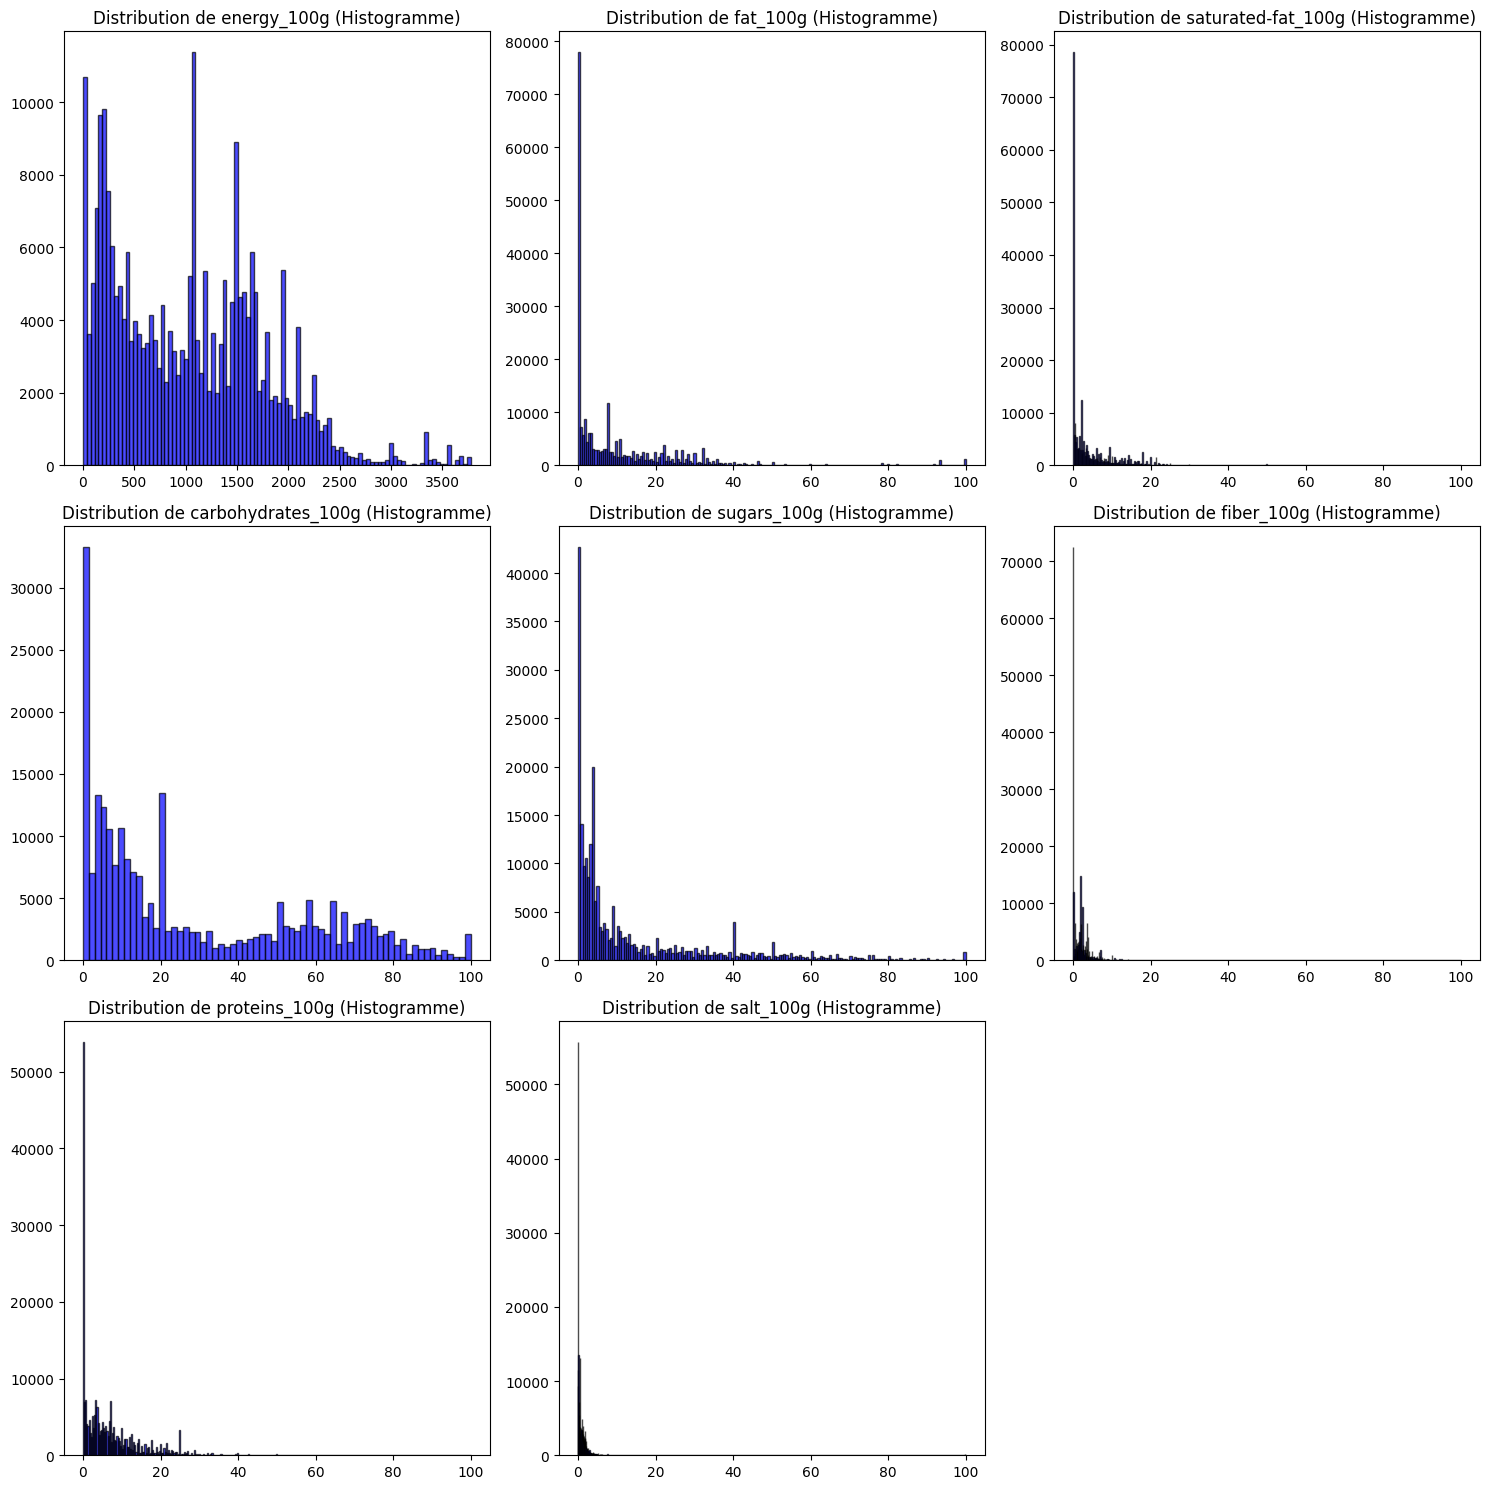

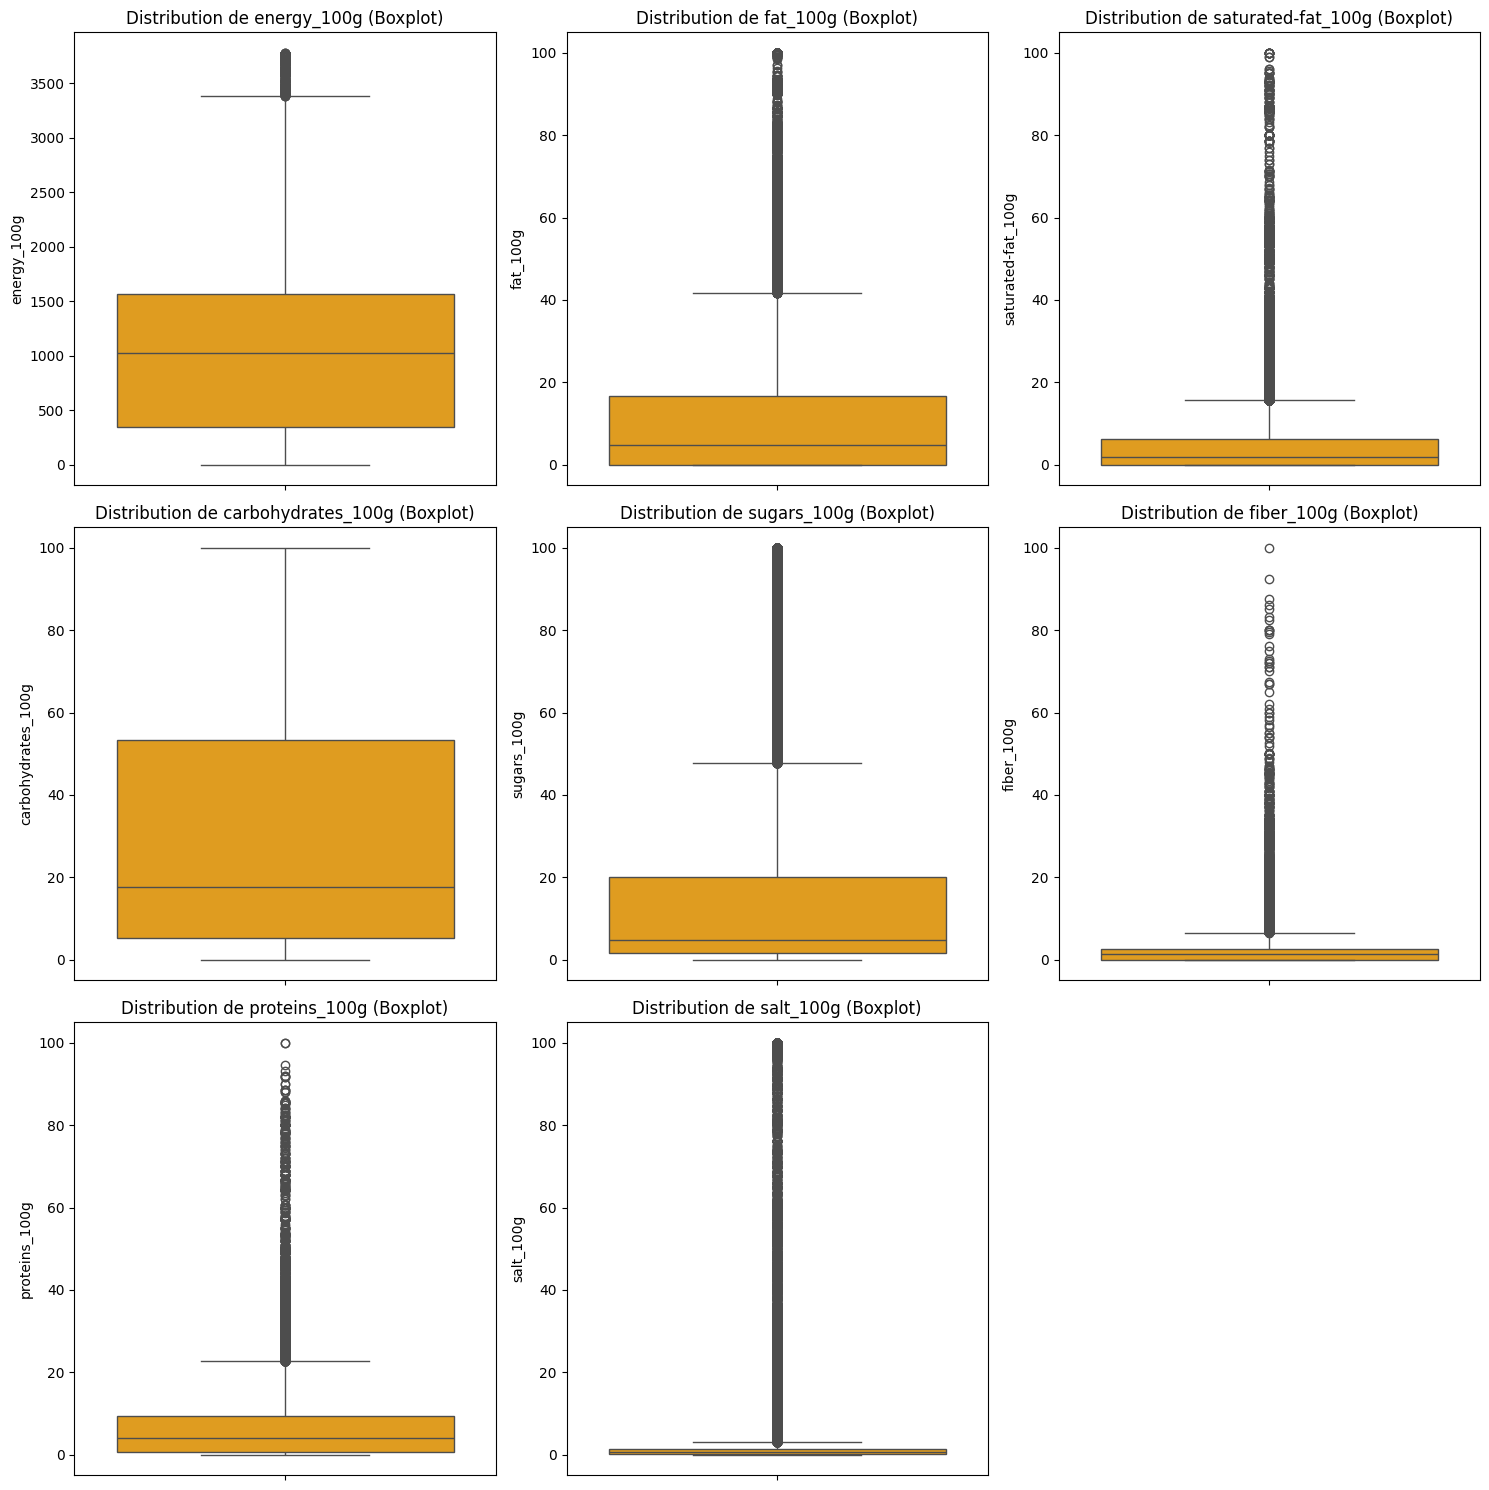



# Analyse univariée pour les features catégorielles



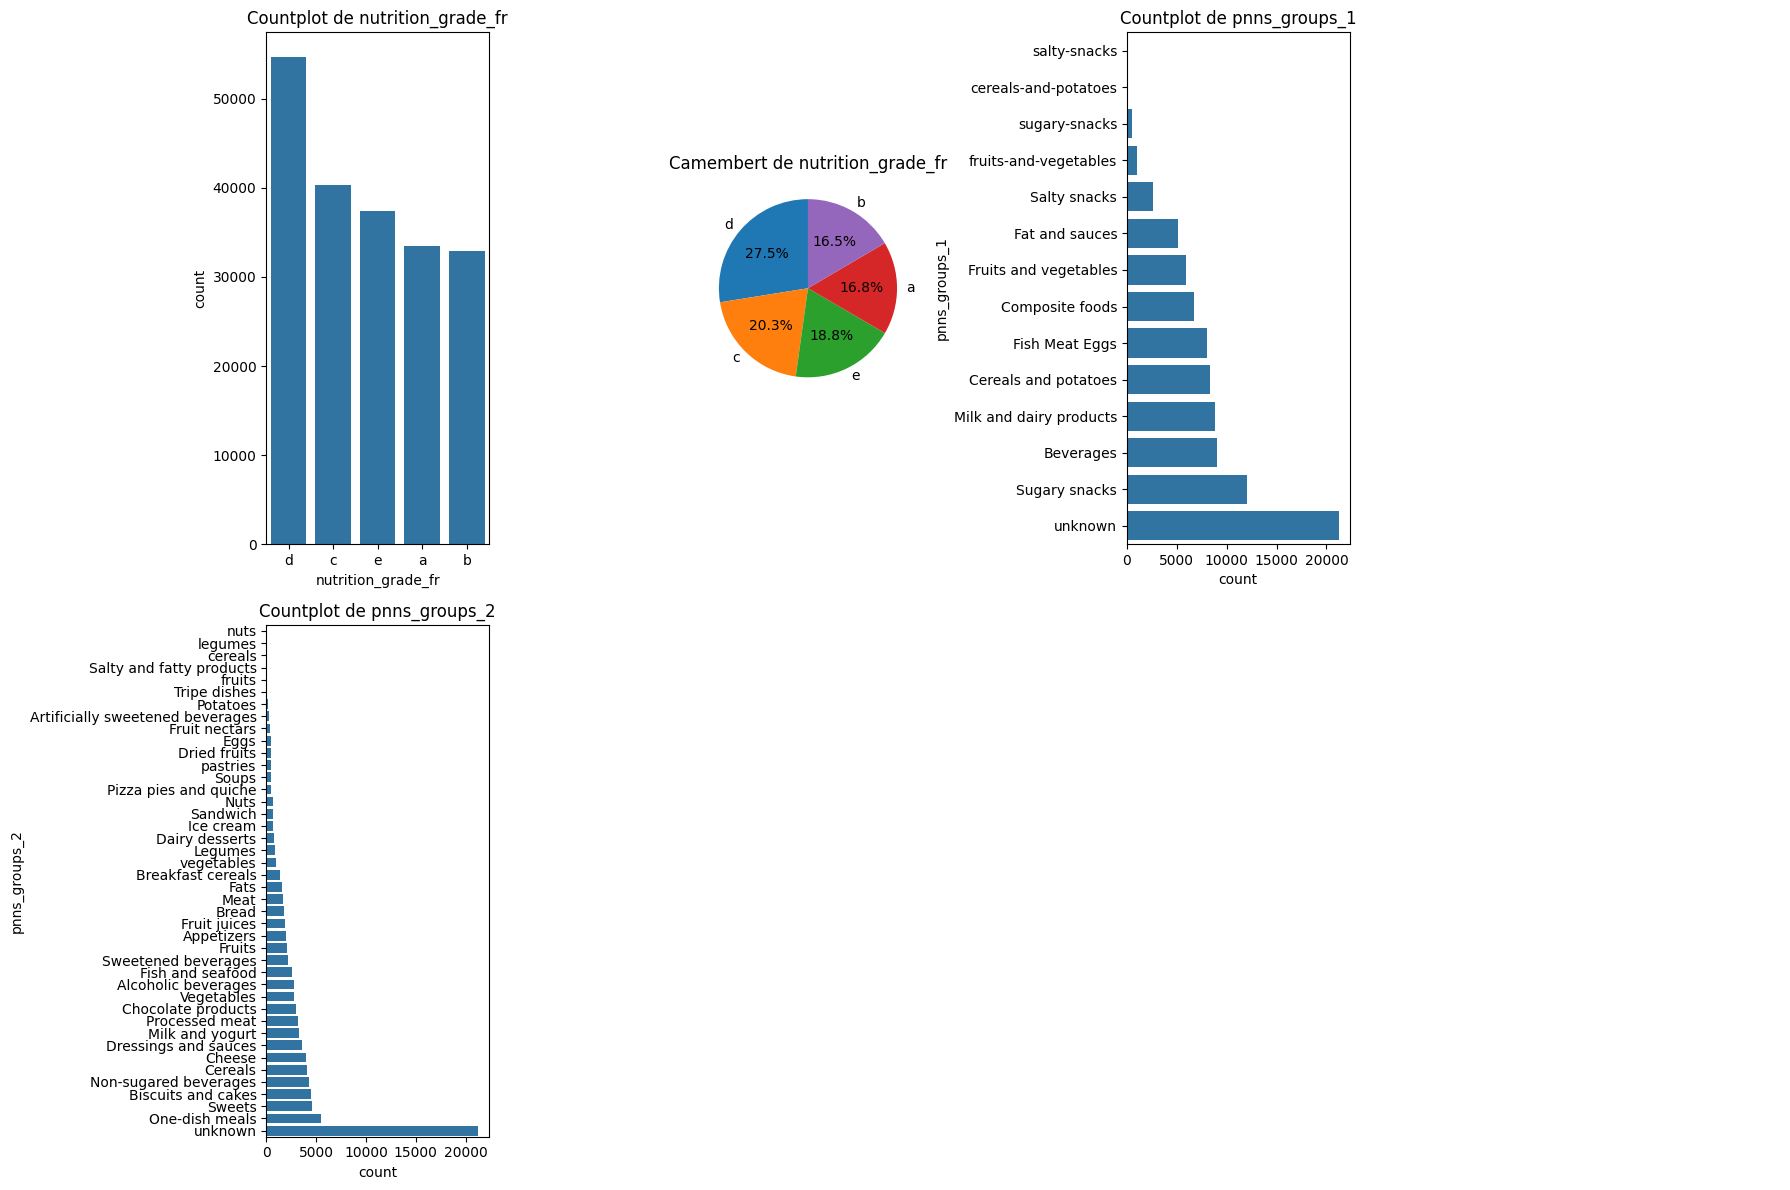

<Figure size 640x480 with 0 Axes>



# Analyse bivariée : scatterplot entre les features numériques



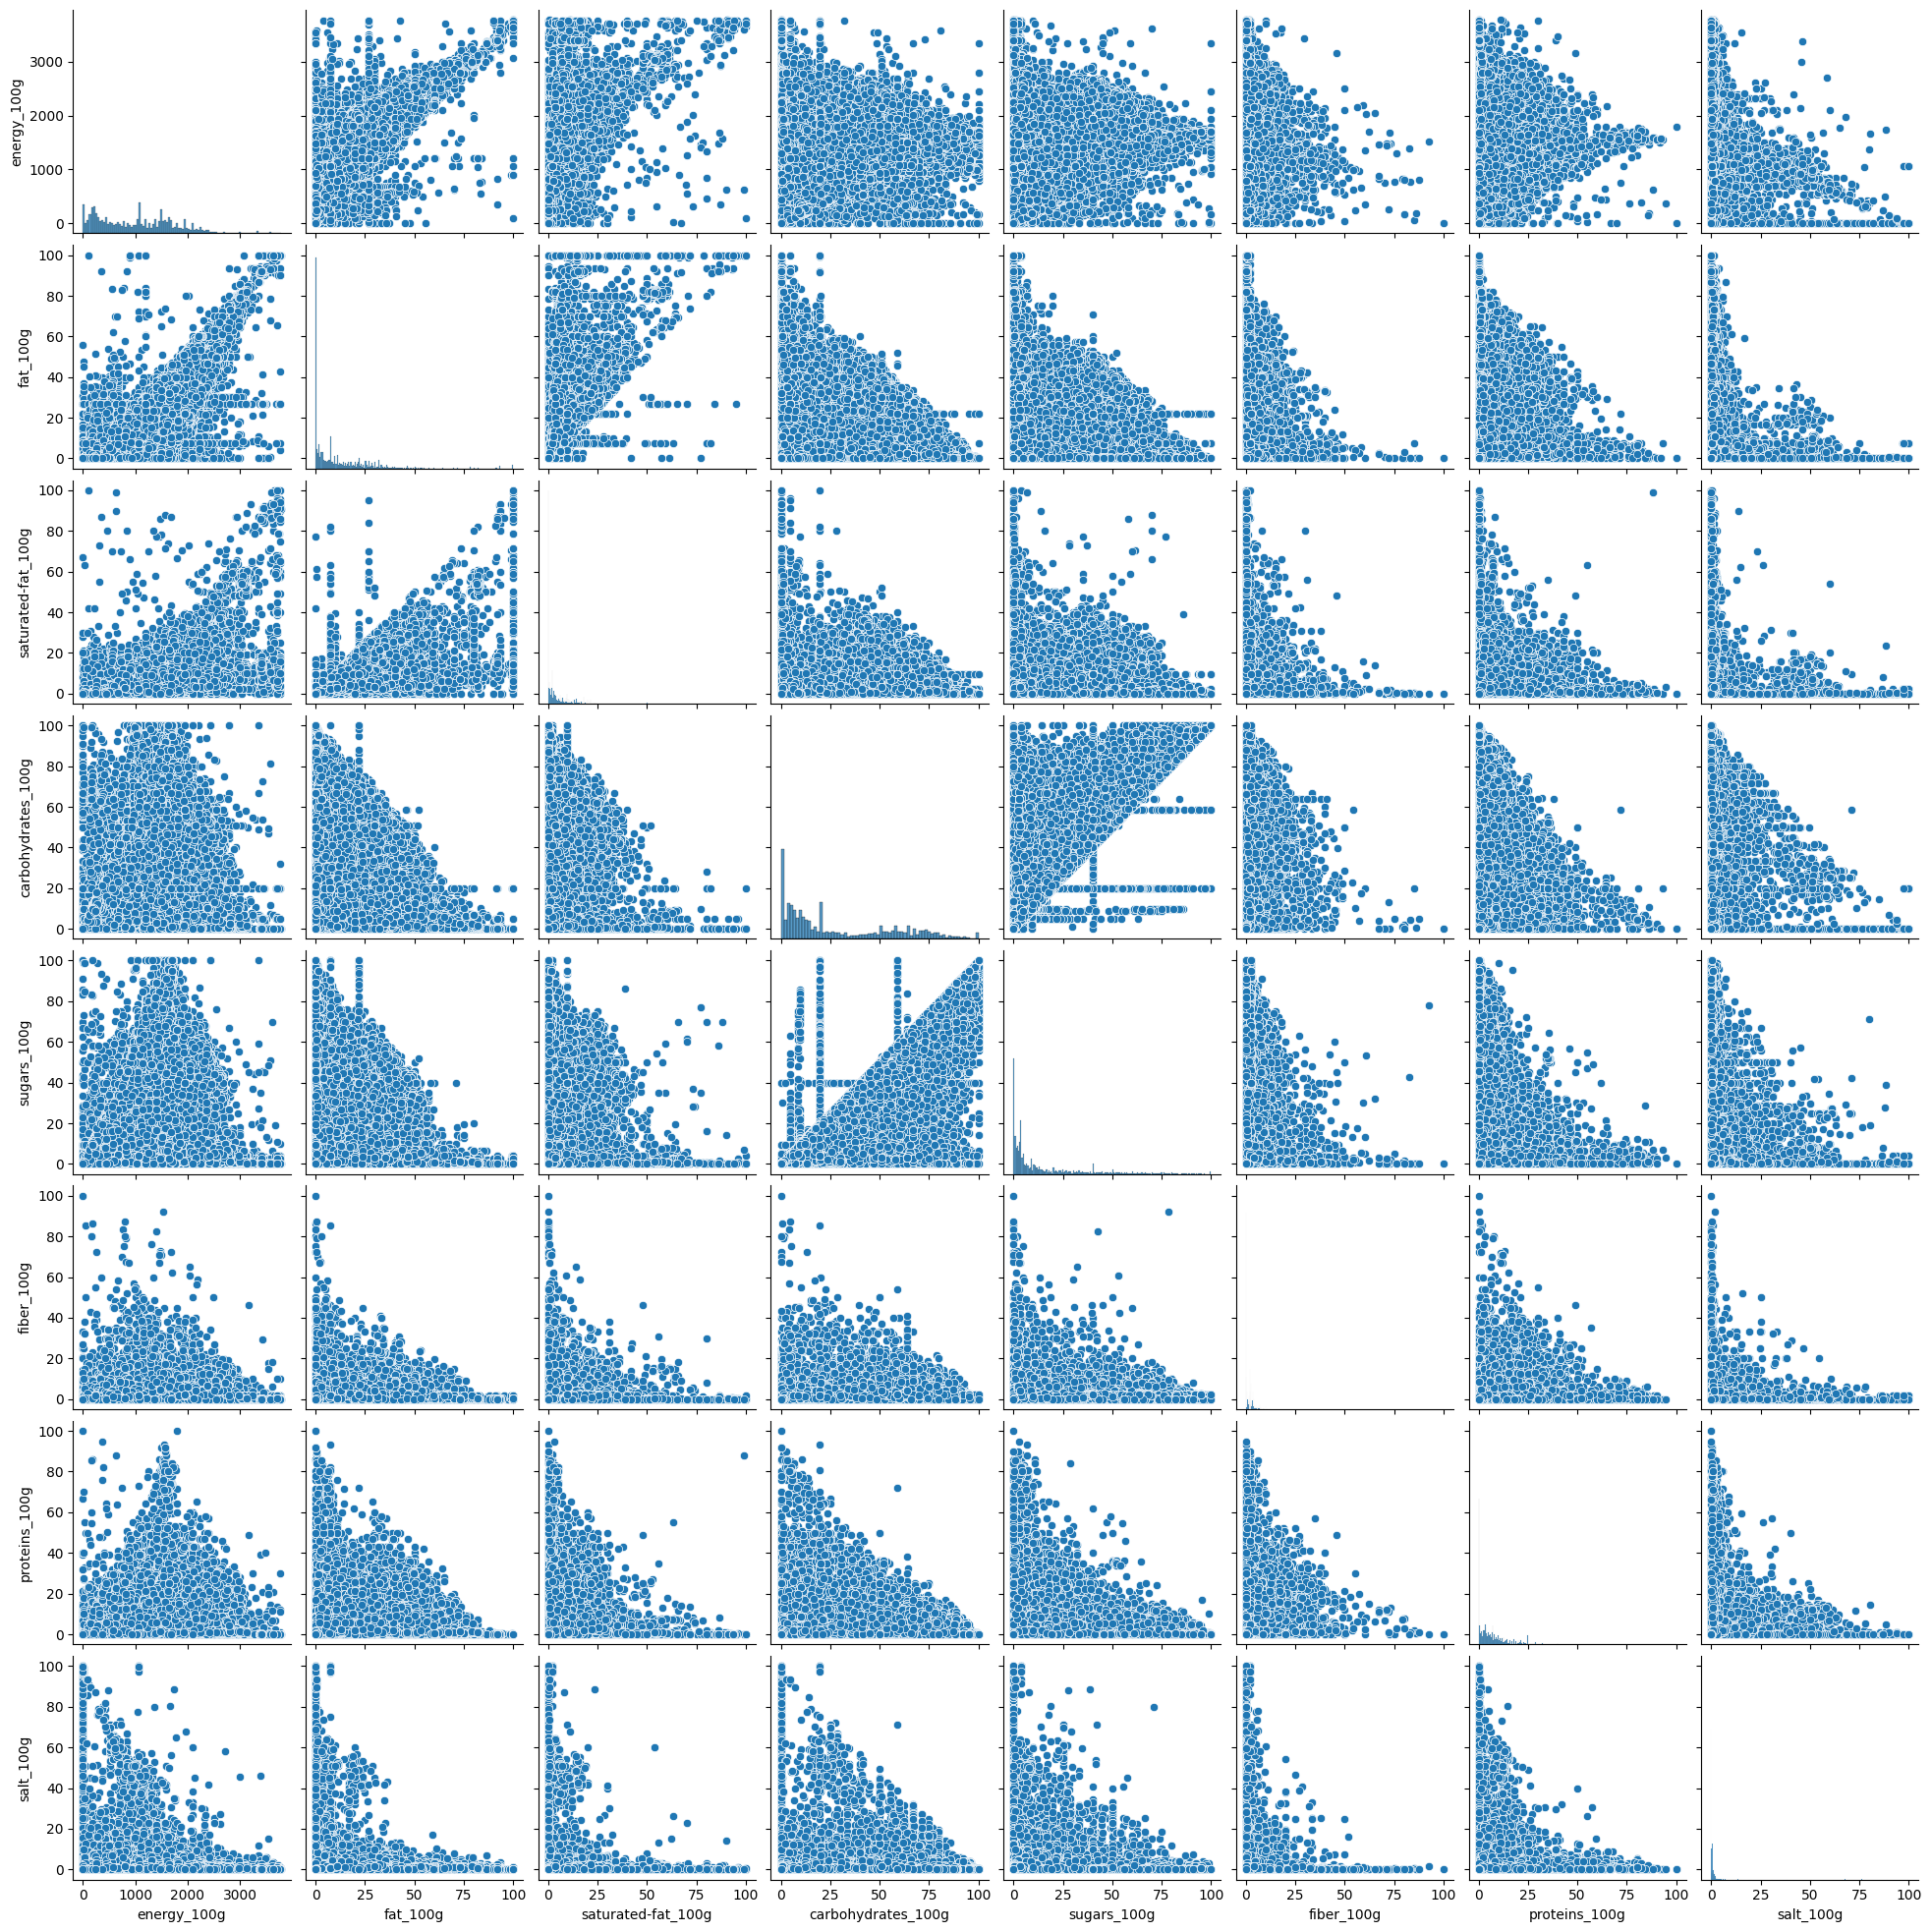



# Analyse bivariée : boxplot entre feature numérique et feature catégorielle (nutrition_grade_fr)



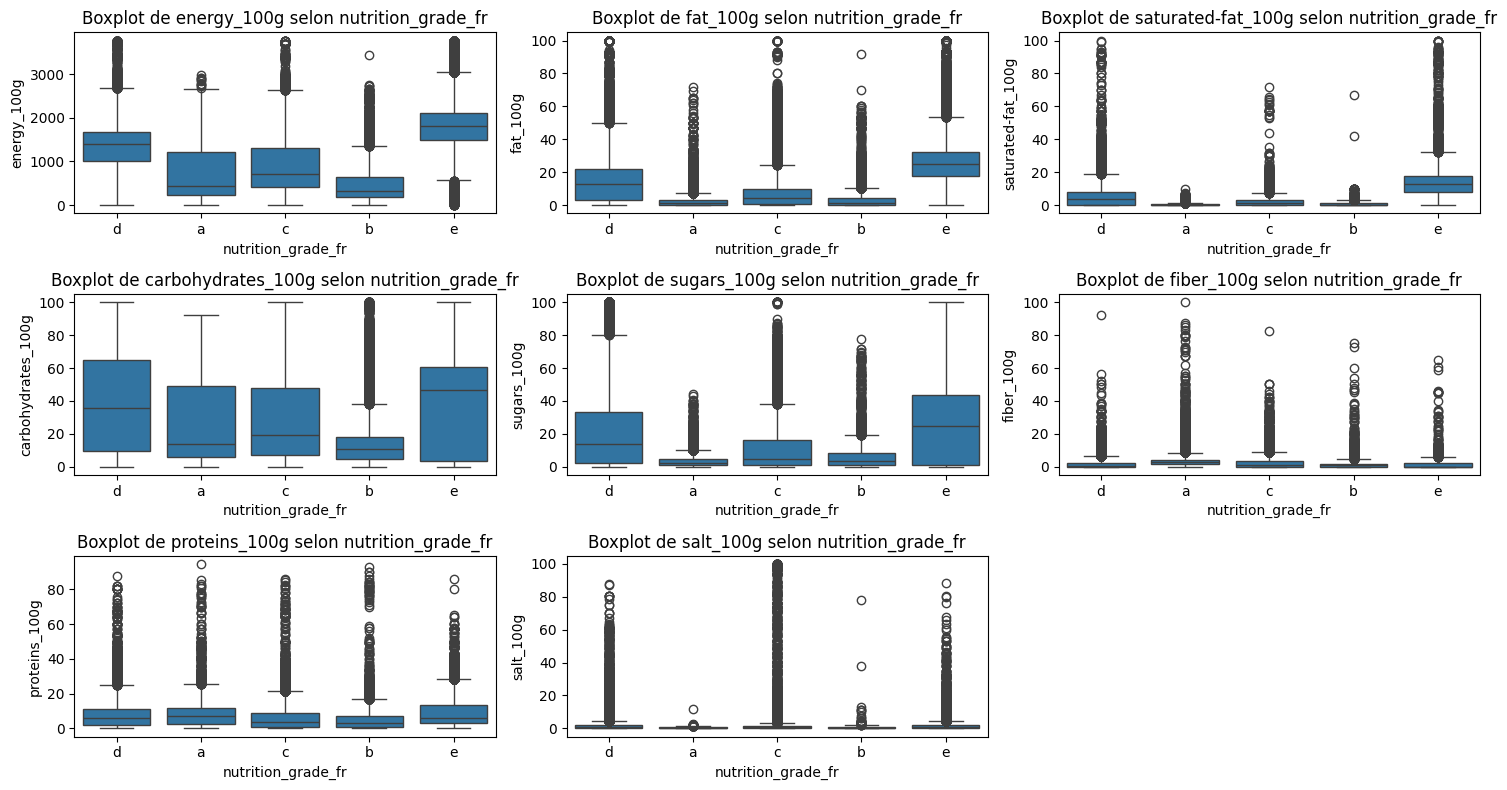

In [31]:
# Import des bibliothèques nécessaires
import matplotlib.pyplot as plt
import seaborn as sns

# Analyse univariée pour les features numériques
numerical_features = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

# Séparation visuelle
print("\n" + "="*80 + "\n")
print("# Analyse univariée pour les features numériques\n")

# Affichage des statistiques descriptives pour les features numériques
print("Statistiques descriptives pour les features numériques :")
print(data[numerical_features].describe())

# Distribution des features numériques
num_cols = 3  # Définissez le nombre de colonnes pour les sous-graphiques
num_rows = (len(numerical_features) - 1) // num_cols + 1

# Création des sous-graphiques pour la distribution des features numériques
plt.figure(figsize=(15, 5 * num_rows))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(num_rows, num_cols, i)

    # Histogramme
    plt.hist(data[feature], bins='auto', alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Distribution de {feature} (Histogramme)')

plt.tight_layout()
plt.show()

# Séparation visuelle
print("\n" + "="*80 + "\n")

# Création des sous-graphiques pour la distribution des features numériques (Boxplots)
plt.figure(figsize=(15, 5 * num_rows))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(num_rows, num_cols, i)

    # Boxplot
    sns.boxplot(data[feature], color='orange')
    plt.title(f'Distribution de {feature} (Boxplot)')

plt.tight_layout()
plt.show()


# Séparation visuelle
print("\n" + "="*80 + "\n")
print("# Analyse univariée pour les features catégorielles\n")

# Analyse univariée pour les features catégorielles
categorical_features = ['nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2']
num_cols_cat = 2  # Définissez le nombre de colonnes pour les sous-graphiques catégoriels
num_rows_cat = (len(categorical_features) - 1) // num_cols_cat + 1

# Création des sous-graphiques pour la countplot et le camembert des features catégorielles
plt.figure(figsize=(18, 6 * num_rows_cat))

for i, feature in enumerate(categorical_features, 1):
    # Countplot
    plt.subplot(num_rows_cat, num_cols_cat * 2, 2 * i - 1)
    if i < len(categorical_features) - 1:  # Pour toutes les features sauf les deux dernières
        sns.countplot(x=feature, data=data, order=data[feature].value_counts().index)
    else:
        order = data[feature].value_counts().sort_values(ascending=True).index
        sns.countplot(y=feature, data=data, order=order)  # Pour les deux dernières features
    plt.title(f'Countplot de {feature}')

    # Pie chart
    plt.subplot(num_rows_cat, num_cols_cat * 2, 2 * i)
    if i == 1:  # Afficher le camembert uniquement pour la première catégorie
        feature_counts = data[feature].value_counts()
        plt.pie(feature_counts, labels=feature_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title(f'Camembert de {feature}')
    else:
        plt.axis('off')  # Désactiver l'axe pour les autres camemberts vides

plt.tight_layout()
plt.show()
    

plt.tight_layout()
plt.show()

# Séparation visuelle
print("\n" + "="*80 + "\n")
print("# Analyse bivariée : scatterplot entre les features numériques\n")

# Analyse bivariée : scatterplot entre les features numériques
# Utilisation de pairplot pour montrer les relations entre toutes les paires de features numériques
sns.pairplot(data[numerical_features])
plt.show()

# Séparation visuelle
print("\n" + "="*80 + "\n")
print("# Analyse bivariée : boxplot entre feature numérique et feature catégorielle (nutrition_grade_fr)\n")

# Analyse bivariée : boxplot entre feature numérique et feature catégorielle (nutrition_grade_fr)
# Utilisation de boxplot pour montrer la distribution de chaque feature numérique par rapport à nutrition_grade_fr
plt.figure(figsize=(15, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x='nutrition_grade_fr', y=feature, data=data)
    plt.title(f'Boxplot de {feature} selon nutrition_grade_fr')
plt.tight_layout()
plt.show()


# Analyse ANOVA et Eta carré

L'analyse de variance (`ANOVA`) et le calcul de l'eta carré (`η²`) ont été effectués pour chaque `variable quantitative` en fonction de la variable qualitative `nutrition_grade_fr`.


In [32]:
import pingouin as pg

# Sélectionner les variables nécessaires
variables_quantitatives = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                            'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
                            'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts_100g']

# Variable qualitative
variable_qualitative = 'nutrition_grade_fr'

# Calculer et afficher l'eta carré pour chaque variable quantitative
for variable in variables_quantitatives:
    # Effectuer une ANOVA
    aov = pg.anova(data=data, dv=variable, between=variable_qualitative, detailed=True)
    
    # Calculer et afficher l'eta carré
    eta_squared = aov.SS[0] / (aov.SS[0] + aov.SS[1])
    print(f"Variable quantitative : {variable}, Eta carré (η²) : {eta_squared}")


Variable quantitative : energy_100g, Eta carré (η²) : 0.4079108987999714
Variable quantitative : fat_100g, Eta carré (η²) : 0.33306633587660944
Variable quantitative : saturated-fat_100g, Eta carré (η²) : 0.40996433324041776
Variable quantitative : carbohydrates_100g, Eta carré (η²) : 0.08265062578348002
Variable quantitative : sugars_100g, Eta carré (η²) : 0.18819274420538779
Variable quantitative : fiber_100g, Eta carré (η²) : 0.06863544861725315
Variable quantitative : proteins_100g, Eta carré (η²) : 0.03619498651246796
Variable quantitative : salt_100g, Eta carré (η²) : 0.021217632662796
Variable quantitative : fruits-vegetables-nuts_100g, Eta carré (η²) : 0.028064375113656035


**Interprétation**

Les résultats de l'analyse ANOVA avec l'eta carré (η²) pour chaque variable quantitative sont les suivants :

- **energy_100g:** Eta carré (η²) = 0.4079
- **fat_100g:** Eta carré (η²) = 0.3331
- **saturated-fat_100g:** Eta carré (η²) = 0.4100
- **carbohydrates_100g:** Eta carré (η²) = 0.0827
- **sugars_100g:** Eta carré (η²) = 0.1882
- **fiber_100g:** Eta carré (η²) = 0.0686
- **proteins_100g:** Eta carré (η²) = 0.0362
- **salt_100g:** Eta carré (η²) = 0.0212
- **fruits-vegetables-nuts_100g:** Eta carré (η²) = 0.0281

Ces valeurs d'eta carré mesurent la proportion de la variance des variables quantitatives expliquée par les modalités de la variable qualitative. Des valeurs plus élevées indiquent un impact plus significatif de la variable qualitative (nutrition_grade_fr) sur la variable quantitative respective.


#### Analyse de Régression Multiple

Dans cette section, nous effectuons une analyse de régression multiple en utilisant le module Statsmodels de Python. L'objectif est d'évaluer l'influence des niveaux de la variable qualitative 'nutrition_grade_fr' sur plusieurs variables quantitatives, à savoir 'energy_100g', 'fat_100g', et 'sugars_100g'.

Nous utilisons le modèle OLS (Ordinary Least Squares) pour chaque variable quantitative en fonction des catégories de 'nutrition_grade_fr'. Les résultats fournis incluent le coefficient de régression, l'erreur standard, la statistique t, et la p-valeur associée à chaque niveau de 'nutrition_grade_fr'. 

In [33]:
# Variables quantitatives à analyser
variables_quantitatives = ['energy_100g', 'fat_100g', 'sugars_100g']

# Variable qualitative pour l'ANOVA
variable_qualitative = 'nutrition_grade_fr'

# Boucle pour chaque variable quantitative
for variable in variables_quantitatives:
    # Créer le modèle d'ANOVA
    formula = f'{variable} ~ C({variable_qualitative})'
    anova_model = ols(formula, data=data).fit()
    
    # Afficher le résumé
    print(f"Variable quantitative : {variable}")
    print(anova_model.summary())

Variable quantitative : energy_100g
                            OLS Regression Results                            
Dep. Variable:            energy_100g   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                 3.422e+04
Date:                Thu, 08 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:18:46   Log-Likelihood:            -1.5379e+06
No. Observations:              198665   AIC:                         3.076e+06
Df Residuals:                  198660   BIC:                         3.076e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

### Interprétation des résultats

##### Variable : energy_100g
- **R-squared :** 0.408
- **Effets de 'nutrition_grade_fr' :** La p-valeur associée à l'effet des niveaux de 'nutrition_grade_fr' sur 'energy_100g' est très faible (p < 0.05), indiquant des différences significatives entre les catégories nutritionnelles.

##### Variable : fat_100g
- **R-squared :** 0.333
- **Effets de 'nutrition_grade_fr' :** La p-valeur associée à l'effet des niveaux de 'nutrition_grade_fr' sur 'fat_100g' est très faible (p < 0.05), indiquant des différences significatives entre les catégories nutritionnelles.

##### Variable : sugars_100g
- **R-squared :** 0.188
- **Effets de 'nutrition_grade_fr' :** La p-valeur associée à l'effet des niveaux de 'nutrition_grade_fr' sur 'sugars_100g' est très faible (p < 0.05), indiquant des différences significatives entre les catégories nutritionnelles.

*Note :* Les valeurs de R-squared indiquent la proportion de variance expliquée par le modèle pour chaque variable. Les faibles p-valeurs associées à l'effet des niveaux de 'nutrition_grade_fr' suggèrent que la catégorie nutritionnelle a un impact significatif sur les variables nutritionnelles étudiées.


# Analyse Statistique de l'Association entre les Groupes d'Aliments (pnns_groups_1) et les Scores Nutritionnels (nutrition_grade_fr)

Dans cette analyse, nous avons examiné l'association entre les groupes d'aliments, définis par la variable `pnns_groups_1`, et les scores nutritionnels attribués, représentés par la variable `nutrition_grade_fr`. Pour ce faire, nous avons utilisé le Test du Chi-2 pour évaluer l'indépendance entre ces deux variables catégorielles.

Le Test du Chi-2 est une méthode statistique puissante pour déterminer si les fréquences observées dans un tableau de contingence diffèrent de ce qui serait attendu en cas d'indépendance. Les résultats obtenus ont révélé une association significative entre les catégories de groupes d'aliments et les grades nutritionnels. 


### 1 - PNNS GROUP 1

Tableau de contingence normalisé entre pnns_groups_1 et nutrition_grade_fr:

nutrition_grade_fr          a     b     c     d     e
pnns_groups_1                                        
Beverages                 258   817  1561   904  2140
Cereals and potatoes     3390  1037  1312   800   103
Composite foods          1305  1763  1584   867    70
Fat and sauces             93   243   964  1664   725
Fish Meat Eggs            540   735  1433  1574  1059
Fruits and vegetables    2371   608   461    47     3
Milk and dairy products   634  1375  1696  2883   265
Salty snacks               50    78   608  1095   354
Sugary snacks              66   332   830  3319  4766
cereals-and-potatoes       11     1     0     0     0
fruits-and-vegetables     557    99    27     0     0
salty-snacks                1     0     0     0     0
sugary-snacks               0     5    30   270    89
unknown                  1615  1887  2518  3073  1894


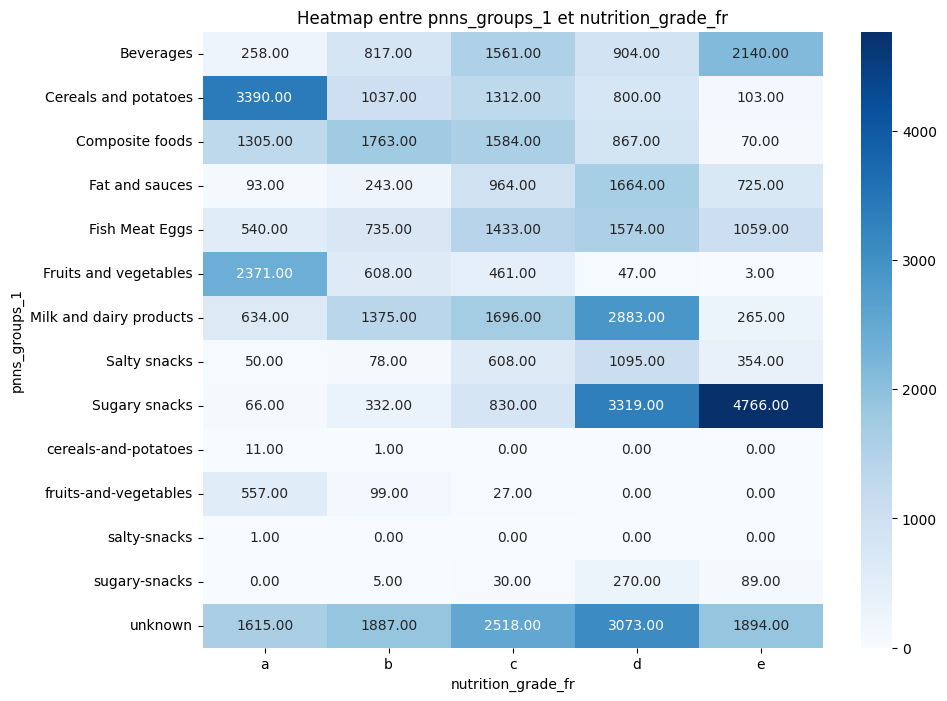


Test du Chi-2 entre pnns_groups_1 et nutrition_grade_fr:
Statistique du Chi-2 = 31865.815905854262
p-valeur = 0.0


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Sélectionner les deux variables qualitatives
variable_qualitative1 = 'pnns_groups_1'
variable_qualitative2 = 'nutrition_grade_fr'

# Créer un tableau croisé des fréquences
contingency_table = pd.crosstab(data[variable_qualitative1], data[variable_qualitative2])

# Appliquer le test du chi-2
chi2, p, _, _ = chi2_contingency(contingency_table)

# Afficher le tableau de contingence normalisé
print(f"Tableau de contingence normalisé entre {variable_qualitative1} et {variable_qualitative2}:\n")
print(contingency_table)

# Créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt=".2f")
plt.title(f"Heatmap entre {variable_qualitative1} et {variable_qualitative2}")
plt.show()

# Afficher les résultats du test
print(f"\nTest du Chi-2 entre {variable_qualitative1} et {variable_qualitative2}:")
print(f"Statistique du Chi-2 = {chi2}")
print(f"p-valeur = {p}")


**Analyse du Test du Chi-2 entre `pnns_groups_1` et `nutrition_grade_fr`**

Le Test du Chi-2 a été appliqué pour évaluer l'indépendance entre les catégories des variables `pnns_groups_1` et `nutrition_grade_fr`. La statistique du Chi-2 obtenue est de 31865.82 avec une p-valeur de 0.0. 

La statistique du Chi-2 mesure l'écart entre les fréquences observées et les fréquences attendues dans le tableau de contingence. Dans notre cas, la valeur très élevée de la statistique du Chi-2 suggère un écart significatif entre les catégories des deux variables, indiquant une association non aléatoire.

La p-valeur, quant à elle, est pratiquement nulle, ce qui renforce l'idée d'une association significative. Concrètement, cela signifie que les catégories de `pnns_groups_1` et `nutrition_grade_fr` ne sont pas indépendantes, mais plutôt liées de manière significative. 

En conclusion, ces résultats fournissent des preuves solides en faveur de l'existence d'une association significative entre les groupes d'aliments (`pnns_groups_1`) et les grades nutritionnels (`nutrition_grade_fr`), démontrant ainsi que la qualité nutritionnelle des aliments peut varier de manière significative en fonction de leur classification dans le groupe PNNS.


### 2 - PNNS GROUP 2

Tableau de contingence normalisé entre pnns_groups_2 et nutrition_grade_fr:

nutrition_grade_fr                   a     b     c     d     e
pnns_groups_2                                                 
Alcoholic beverages                  0     3     4    31    21
Appetizers                          24    66   497   822   282
Artificially sweetened beverages     3    79    80    47    18
Biscuits and cakes                  22    39   263  1410  2027
Bread                              506   369   395   177    22
Breakfast cereals                  269   107   502   327    11
Cereals                           2106   493   374   232    53
Cheese                             188    95   320  2179   165
Chocolate products                  16    31    66   389  1916
Dairy desserts                      34    79   436   131    12
Dressings and sauces                91   241   774  1123   326
Dried fruits                        62   127   151    20     0
Eggs                               109   

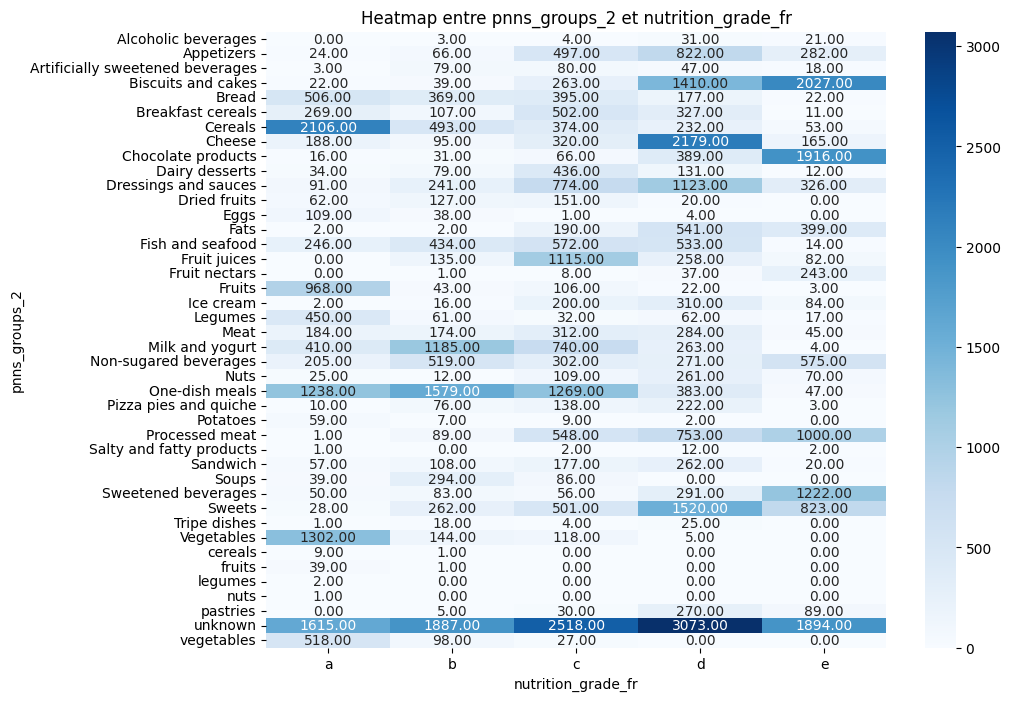


Test du Chi-2 entre pnns_groups_2 et nutrition_grade_fr:
Statistique du Chi-2 = 53134.33478034505
p-valeur = 0.0


In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Sélectionner les deux variables qualitatives
variable_qualitative1 = 'pnns_groups_2'
variable_qualitative2 = 'nutrition_grade_fr'

# Créer un tableau croisé des fréquences
contingency_table = pd.crosstab(data[variable_qualitative1], data[variable_qualitative2])

# Appliquer le test du chi-2
chi2, p, _, _ = chi2_contingency(contingency_table)

# Afficher le tableau de contingence normalisé
print(f"Tableau de contingence normalisé entre {variable_qualitative1} et {variable_qualitative2}:\n")
print(contingency_table)

# Créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt=".2f")
plt.title(f"Heatmap entre {variable_qualitative1} et {variable_qualitative2}")
plt.show()

# Afficher les résultats du test
print(f"\nTest du Chi-2 entre {variable_qualitative1} et {variable_qualitative2}:")
print(f"Statistique du Chi-2 = {chi2}")
print(f"p-valeur = {p}")


**Analyse du Test du Chi-2 entre `pnns_groups_2` et `nutrition_grade_fr`**

Le Test du Chi-2 a été appliqué pour évaluer l'indépendance entre les catégories des variables `pnns_groups_2` et `nutrition_grade_fr`. La statistique du Chi-2 obtenue est de 53134,33 avec une p-valeur de 0.0. 

La statistique du Chi-2 mesure l'écart entre les fréquences observées et les fréquences attendues dans le tableau de contingence. Dans notre cas, la valeur très élevée de la statistique du Chi-2 suggère un écart significatif entre les catégories des deux variables, indiquant une association non aléatoire.

La p-valeur, quant à elle, est pratiquement nulle, ce qui renforce l'idée d'une association significative. Concrètement, cela signifie que les catégories de `pnns_groups_2` et `nutrition_grade_fr` ne sont pas indépendantes, mais plutôt liées de manière significative. 

En conclusion, ces résultats fournissent des preuves solides en faveur de l'existence d'une association significative entre les groupes d'aliments (`pnns_groups_2`) et les grades nutritionnels (`nutrition_grade_fr`), démontrant ainsi que la qualité nutritionnelle des aliments peut varier de manière significative en fonction de leur classification dans le groupe PNNS.

petite correction sur la semaine prochaine: 

- p value pour la partie anova
- dénormaliser la partie table de contingence 


Variance expliquée par chaque composante:
[0.29087555 0.21895653 0.13551417 0.10778035 0.09555947 0.07164362
 0.04411948 0.03189487 0.00365597]

Variance expliquée cumulative:
[0.29087555 0.50983208 0.64534625 0.75312659 0.84868606 0.92032968
 0.96444916 0.99634403 1.        ]


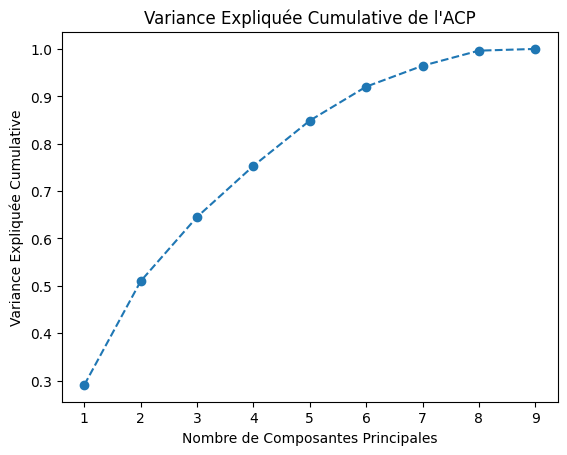

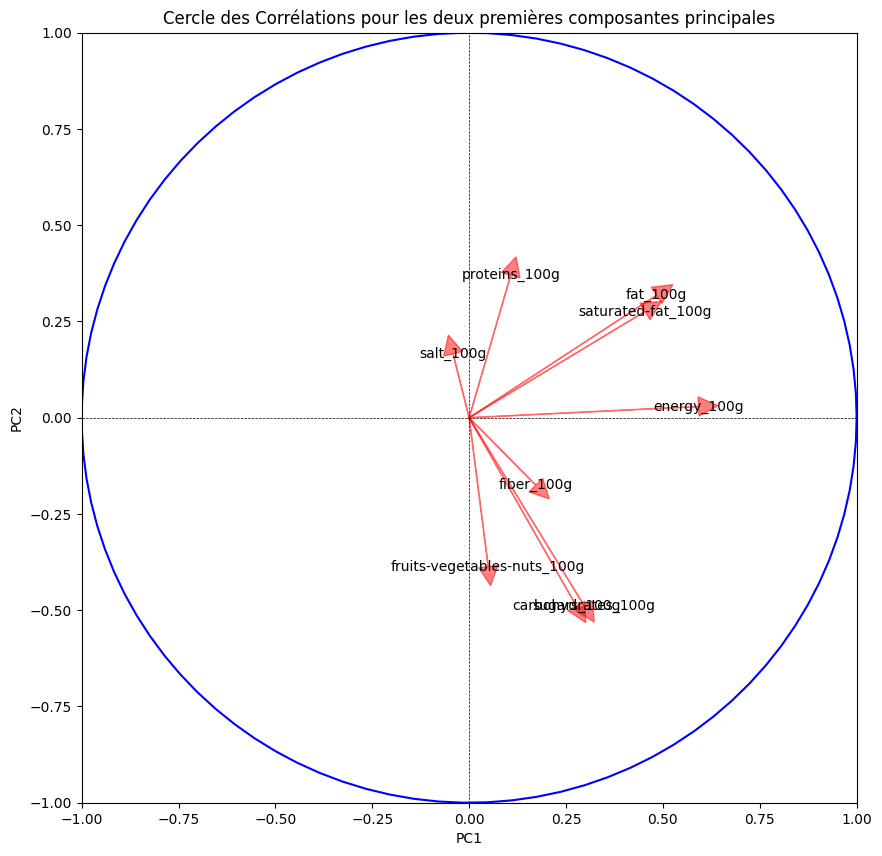


Combinaisons linéaires des deux premières composantes principales:

Combinaison pour PC1:
energy_100g                    0.591824
fat_100g                       0.483858
saturated-fat_100g             0.453775
carbohydrates_100g             0.296830
sugars_100g                    0.276406
fiber_100g                     0.171965
proteins_100g                  0.107198
salt_100g                     -0.041476
fruits-vegetables-nuts_100g    0.049213 * PC1

Combinaison pour PC2:
energy_100g                    0.029102
fat_100g                       0.318117
saturated-fat_100g             0.275957
carbohydrates_100g            -0.488213
sugars_100g                   -0.488667
fiber_100g                    -0.175179
proteins_100g                  0.369979
salt_100g                      0.166158
fruits-vegetables-nuts_100g   -0.386618 * PC2


In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Sélectionner les variables nécessaires
variables_quantitatives = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                            'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
                            'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts_100g']

# Créer un sous-ensemble du dataframe avec seulement les variables quantitatives
data_quantitative = data[variables_quantitatives]

# Supprimer les lignes contenant des valeurs manquantes dans les variables quantitatives
data_quantitative_cleaned = data_quantitative.dropna()

# Standardiser les données
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_quantitative_cleaned)

# Appliquer l'ACP
pca = PCA()
pca_result = pca.fit_transform(data_standardized)

# Créer un DataFrame avec les composantes principales
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(len(variables_quantitatives))])

# Afficher la variance expliquée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

print("Variance expliquée par chaque composante:")
print(explained_variance_ratio)

print("\nVariance expliquée cumulative:")
print(cumulative_explained_variance)

# Visualiser la variance expliquée cumulative
plt.plot(range(1, len(variables_quantitatives) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title("Variance Expliquée Cumulative de l'ACP")
plt.xlabel("Nombre de Composantes Principales")
plt.ylabel("Variance Expliquée Cumulative")
plt.show()

# Appliquer l'ACP avec deux composantes principales
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_standardized)

# Créer un DataFrame avec les charges des variables sur les composantes principales
loadings_df = pd.DataFrame(data=pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=variables_quantitatives)

# Visualiser le cercle des corrélations
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Afficher les noms des variables
for variable in variables_quantitatives:
    ax.text(loadings_df.loc[variable, 'PC1'], loadings_df.loc[variable, 'PC2'], variable, ha='center', va='center', fontsize=10)

# Afficher les flèches des corrélations
for variable in variables_quantitatives:
    ax.arrow(0, 0, loadings_df.loc[variable, 'PC1'], loadings_df.loc[variable, 'PC2'], color='red', alpha=0.5, head_width=0.05, head_length=0.05)

# Titre et axes
ax.set_title('Cercle des Corrélations pour les deux premières composantes principales')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Générer des points pour le cercle
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)

# Tracer le cercle en bleu
plt.plot(x_circle, y_circle, color='blue')

plt.show()

# Imprimer les combinaisons linéaires des deux premières composantes principales
print("\nCombinaisons linéaires des deux premières composantes principales:")
for i in range(2):
    combination = f"{loadings_df.loc[:, f'PC{i+1}'].to_string(index=True)} * PC{i+1}"
    print(f"\nCombinaison pour PC{i+1}:\n{combination}")





Rajouter les commentaires et interprétations des graphiques sur la partie ACP pour la prochaine fois.

Etre en mesure d'expliquer tout ce que j'ai fait. angle et longueurs des fleches du cercle de coréllation par exemple. p value. a quoi sert acp.

Regarder dans le projet si il demander un support de type powerpoint.

Commercer à voir le projet suivant.